# First assignment: Compute different measures on a realistic graph

In [6]:
import numpy as np
import urllib.request as urllib
import io
import zipfile

import networkx as nx
import matplotlib.pyplot as plt
import scipy
import collections

## Load dataset

In [9]:
url = "http://nrvis.com/download/data/inf/inf-openflights.zip"

sock = urllib.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("readme.html").decode()  # read info file
edges = zf.read("inf-openflights.edges").decode()  # read edges data

# split each row
edges = edges.split("\n")


# create graph
G = nx.Graph()


for row in edges:
    if len(row.split(" ")) == 1:
        continue

    print(row.split(" "))
    source, target = row.split(" ")
    source = int(source)
    target = int(target)

    # add nodes if not in yet
    if source not in G:
        G.add_node(source)
        
    if target not in G:
        G.add_node(target)
        
    # add edge and weight
    G.add_edge(source, target)
        
        

['%', 'asym', 'unweighted']


ValueError: too many values to unpack (expected 2)

In [10]:
# create graph
G = nx.Graph()

with open("dataset/inf-openflights.edges") as edges:
    for row in edges:
        if len(row.split(" ")) == 1:
            continue
        
        source, target = row.split(" ")[:2]
        source = int(source)
        target = int(target)

        # add nodes if not in yet
        if source not in G:
            G.add_node(source)
        
        if target not in G:
            G.add_node(target)
        
        # add edge and weight
        G.add_edge(source, target)

In [12]:


# number of nodes
print("Number of nodes: ", nx.number_of_nodes(G))

# number of links
print("Number of edges: ", nx.number_of_edges(G))


Number of nodes:  2939
Number of edges:  15677


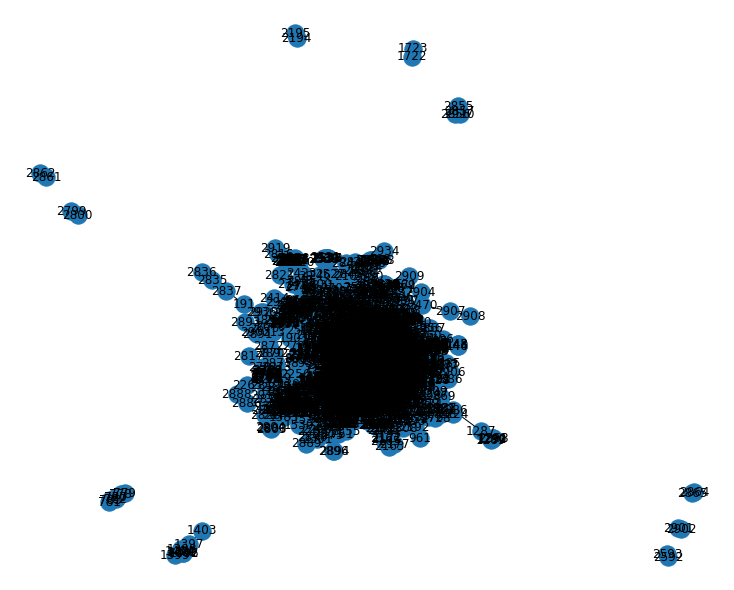

In [13]:
# draw
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True)
plt.show()

# poi con quello reale bisogna usare Gephi

### Compute metrics

#### Find the largest connected component if necessary

In [14]:
if not nx.is_connected(G):
    print("graph not connected! From now on the largest component will be considered as the graph")  
    #G =  G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0]).copy()
    
print("Number of nodes of the giant component: ", nx.number_of_nodes(G))


# o bisogna considerare tutte le componenti in qualche modo? da chiedere

graph not connected! From now on the largest component will be considered as the graph
Number of nodes of the giant component:  2939


#### 1.Does the graph have the same characteristics of a random or a power-law network?

In [15]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def nth_moment(g,n):
    s = 0
    for node in g.nodes:
        s += g.degree[node] ** n
    return (s/len(g))

def nth_moment_v2(g,n):
    degree_np = np.array(list(dict(g.degree).values()))
    return (sum(degree_np**n)/len(g))

<ipython-input-15-6574cbca94d4>:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


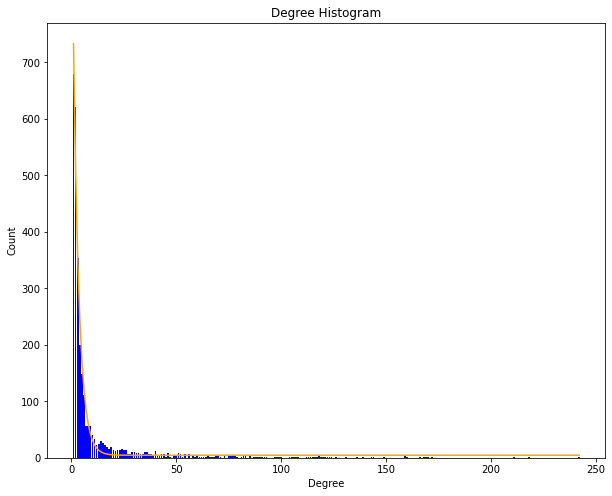

In [16]:
plt.figure(figsize=(10, 8))

degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

#fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
#ax.set_xticks([d for d in deg])
#ax.set_xticklabels(deg)

popt, pcov = curve_fit(func, np.array(deg), np.array(cnt))

plt.plot(deg, func(np.array(deg), *popt), color='orange')
plt.show()

# la distribuzione dovrebbe darci un'idea ma credo vadano pure usate le ultime formule che ha spiegato (quelle con gamma per intenderci) 

##### Provo http://networksciencebook.com/chapter/4#advanced-c


In [17]:
from itertools import count, islice

def binom(n, k):
    v = 1
    for i in range(k):
        v *= (n - i) / (i + 1)
    return v

def zeta(s, t=100):
    if s == 1: return complex("inf")
    term = (1 / 2 ** (n + 1) * sum((-1) ** k * binom(n, k) * (k + 1) ** -s 
                                   for k in range(n + 1)) for n in count(0))
    return sum(islice(term, t)) / (1 - 2 ** (1 - s))

def zeta2(s, t=10000):
    if s == 1: return float("inf")
    #term = ((-1)**(n - 1) / (n ** s) for n in count(1))
    #return sum(islice(term, t)) / (1 - 2**(1 - s))
    term = ((-1) ** n * n ** -s for n in count(1))
    return sum(islice(term, t)) / (2 ** (1 - s) -  1)

def zeta3(s, t=100):
    if s == 1: return float("inf")
    term = (1 / 2 ** (n + 1) * sum((-1) ** k * binom(n, k) * (k + 1) ** -s 
                                   for k in range(n + 1)) for n in count(0))
    return sum(islice(term, t)) / (1 - 2 ** (1 - s))

In [18]:
#from scipy.special import zeta


gamma = 0 # γ
N = nx.number_of_nodes(G)

list_D = {}
pk_list = []

deg = np.array(deg)


for Kmin in deg:
    
    gamma = np.array([np.log(ki/(Kmin-0.5)) for ki in dict(G.degree()).values()], dtype=np.float64()).sum()
    
    gamma = 1 + N / (gamma)
    
    
    pk = lambda gamma, k: 1/(zeta(gamma, Kmin) * k**gamma)
    CDF = lambda gamma, k: (1 - (zeta3(gamma, k))/zeta3(gamma, Kmin))    
    
    D = max([abs( (len(deg[deg <= Kmin])/len(deg)) - CDF(gamma, k)) for k in deg[deg >= Kmin]]) # empirical distribution function - model CDF
    list_D[(gamma, Kmin)] = D

# find Min
best_D= sorted(list_D.items(), key=lambda item: item[1], reverse=True)[0]

print(best_D)

KeyboardInterrupt: 

In [ ]:

plt.scatter([ k for g, k in list_D.keys()], list_D.values(), c='m')
plt.xlabel("k")
plt.ylabel("D")

#### 2. Which are the most important nodes, with respect to a given centrality measure?

In [ ]:
# da scegliere le misure

k= 10 # top k node

betwenness = nx.betweenness_centrality(G)

# select first k
betwenness = dict(sorted(betwenness.items(), key=lambda item: item[1], reverse=True)[:k])

print(betwenness)

closeness = nx.closeness_centrality(G)

# select first k
closeness = dict(sorted(closeness.items(), key=lambda item: item[1], reverse=True)[:k])

print(closeness)

print("Average clustering: ", nx.average_clustering(G))



#### 3. Are the paths short with respect to the size of the network?


In [ ]:
print("Diameter: ", nx.diameter(G))
print("Average distance ", nx.average_shortest_path_length(G))


#### 4. Is the network dense?


In [ ]:
# da fare più avanti nel corso

#### 5. Is the network assortative?

In [ ]:
# da fare più avanti nel corso